In [1]:
# Librerías básicas
import os
import re
import tarfile
import numpy as np
import pandas as pd
from glob import glob
import gzip
import time
import warnings
import concurrent.futures
import scipy.signal
from scipy.signal import butter, filtfilt, stft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from collections import Counter
from tqdm import tqdm
import tensorflow as tf
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
warnings.filterwarnings('ignore')
plt.style.use('default')
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Todas las librerías importadas correctamente")
print(f"📊 TensorFlow version: {tf.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"📈 Scikit-learn version: {__import__('sklearn').__version__}")



✅ Todas las librerías importadas correctamente
📊 TensorFlow version: 2.19.0
🔢 NumPy version: 2.0.2
🐼 Pandas version: 2.2.2
📈 Scikit-learn version: 1.6.1


In [4]:
# 1. Descargar el dataset desde UCI
!wget https://archive.ics.uci.edu/static/public/121/eeg+database.zip -O eeg_alcohol.zip


--2025-10-27 18:36:41--  https://archive.ics.uci.edu/static/public/121/eeg+database.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘eeg_alcohol.zip’

eeg_alcohol.zip         [              <=>   ] 762.44M  10.5MB/s    in 59s     

2025-10-27 18:37:41 (12.8 MB/s) - ‘eeg_alcohol.zip’ saved [799481741]



In [5]:
# 2. Revisar qué tipo de archivo es realmente
!file eeg_alcohol.zip

# 3. Crear carpeta destino
!mkdir -p /content/eeg_data

# 4. Intentar descomprimir (UCI a veces lo da en .tar.gz aunque diga .zip)
!unzip -o eeg_alcohol.zip -d /content/eeg_data || tar -xvzf eeg_alcohol.zip -C /content/eeg_data || tar -xvf eeg_alcohol.zip -C /content/eeg_data

# 5. Listar los archivos extraídos
!ls -lh /content/eeg_data

eeg_alcohol.zip: Zip archive data, at least v2.0 to extract, compression method=deflate
Archive:  eeg_alcohol.zip
  inflating: /content/eeg_data/SMNI_CMI_TEST.tar.gz  
  inflating: /content/eeg_data/SMNI_CMI_TRAIN.tar.gz  
  inflating: /content/eeg_data/alcoholic.gif  
  inflating: /content/eeg_data/control.gif  
  inflating: /content/eeg_data/eeg.data.html  
  inflating: /content/eeg_data/eeg.full.html  
  inflating: /content/eeg_data/eeg.html  
   creating: /content/eeg_data/eeg_full/
  inflating: /content/eeg_data/eeg_full/co2a0000364.tar.gz  
  inflating: /content/eeg_data/eeg_full/co2a0000365.tar.gz  
  inflating: /content/eeg_data/eeg_full/co2a0000368.tar.gz  
  inflating: /content/eeg_data/eeg_full/co2a0000369.tar.gz  
  inflating: /content/eeg_data/eeg_full/co2a0000370.tar.gz  
  inflating: /content/eeg_data/eeg_full/co2a0000371.tar.gz  
  inflating: /content/eeg_data/eeg_full/co2a0000372.tar.gz  
  inflating: /content/eeg_data/eeg_full/co2a0000375.tar.gz  
  inflating: /conten

In [6]:
# Extraer entrenamiento
with tarfile.open("/content/eeg_data/SMNI_CMI_TRAIN.tar.gz", "r:gz") as tar:
    tar.extractall("/content/eeg_data/train")

# Extraer prueba
with tarfile.open("/content/eeg_data/SMNI_CMI_TEST.tar.gz", "r:gz") as tar:
    tar.extractall("/content/eeg_data/test")

# Extraer dataset adicional
with tarfile.open("/content/eeg_data/smni_eeg_data.tar.gz", "r:gz") as tar:
    tar.extractall("/content/eeg_data/extra")

# Listar 50 archivos para ver su estructura real
for root, dirs, files in os.walk("/content/eeg_data"):
    for f in files[:50]:
        print(os.path.join(root, f))# Listar 50 archivos para ver su estructura real
for root, dirs, files in os.walk("/content/eeg_data"):
    for f in files[:50]:
        print(os.path.join(root, f))

/content/eeg_data/eeg.data.html
/content/eeg_data/eeg_full.tar
/content/eeg_data/eeg.html
/content/eeg_data/SMNI_CMI_TEST.tar.gz
/content/eeg_data/control.gif
/content/eeg_data/eeg.full.html
/content/eeg_data/smni_eeg_data.tar.gz
/content/eeg_data/alcoholic.gif
/content/eeg_data/SMNI_CMI_TRAIN.tar.gz
/content/eeg_data/test/SMNI_CMI_TEST/README
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.069.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.089.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.107.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.030.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.105.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.048.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.095.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.119.gz
/content/eeg_data/test/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.109.gz
/content/eeg_da

In [7]:
# Carpeta donde están los archivos EEG comprimidos
data_dir = "/content/eeg_data/test"

rows = []

# Buscar todos los archivos .gz en la carpeta
for file_path in glob(os.path.join(data_dir, "**/*.gz"), recursive=True):
    file_id = os.path.basename(file_path)  # nombre del archivo para identificarlo
    # Extraer el grupo del nombre del archivo: 'a' = alcohólico, 'c' = control, sino 'unknown'
    match = re.search(r'co\d(a|c)', file_id)
    group = match.group(1) if match else 'unknown'

    with gzip.open(file_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue  # ignorar metadatos
            parts = line.strip().split()
            trial = int(parts[0])
            channel = parts[1]
            timepoint = int(parts[2])
            value = float(parts[3])
            # ahora agregamos group como último elemento
            rows.append((file_id, trial, channel, timepoint, value, group))

# Convertir a DataFrame (incluyendo ahora 'group')
df = pd.DataFrame(rows, columns=["file_id", "trial", "channel", "time", "value", "group"])

print(df.head())
print("Dimensiones totales:", df.shape)
print("Archivos procesados:", df['file_id'].nunique())
print("Trials únicos:", df['trial'].nunique())
print("Grupos encontrados:", df['group'].unique())


                 file_id  trial channel  time  value group
0  co2a0000365.rd.069.gz     69     FP1     0 -1.689     a
1  co2a0000365.rd.069.gz     69     FP1     1 -5.107     a
2  co2a0000365.rd.069.gz     69     FP1     2 -8.525     a
3  co2a0000365.rd.069.gz     69     FP1     3 -9.501     a
4  co2a0000365.rd.069.gz     69     FP1     4 -7.548     a
Dimensiones totales: (9830400, 6)
Archivos procesados: 600
Trials únicos: 67
Grupos encontrados: ['a' 'c']


In [8]:
def plot_trial(trial_id):
    """
    Genera y muestra gráficos de señales EEG y un heatmap para un trial específico,
    mostrando resumen de información antes de las gráficas.
    Usa el DataFrame df ya creado, que debe contener la columna 'group'.
    """
    trial_df = df[df["trial"] == trial_id].copy()

    if trial_df.empty:
        print(f"Trial {trial_id} no encontrado")
        return

    group_code = trial_df["group"].iloc[0]
    if group_code == 'a':
        grupo_texto = "Mostrando datos para un sujeto Alcohólico"
        group_label = "Alcohólico"
    elif group_code == 'c':
        grupo_texto = "Mostrando datos para un sujeto No Alcohólico (Control)"
        group_label = "No Alcohólico (Control)"
    else:
        grupo_texto = f"Mostrando datos para un sujeto Desconocido ({group_code})"
        group_label = f"Desconocido ({group_code})"
    print(f"{grupo_texto}, trial: {trial_id}")
    print(f"Canales encontrados en el trial: {trial_df['channel'].unique()}")

    # --- GRAFICACIÓN ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sampling_rate = 256
    trial_df["time_seconds"] = trial_df["time"] / sampling_rate

    # Gráfico de señales por canal
    for ch in trial_df["channel"].unique():
        ch_data = trial_df[trial_df["channel"] == ch].copy()
        ch_data = ch_data.sort_values("time_seconds")
        axes[0].plot(ch_data["time_seconds"], ch_data["value"], label=ch, alpha=0.6)
    axes[0].set_xlabel("Tiempo (segundos)")
    axes[0].set_ylabel("Amplitud (µV)")
    if len(trial_df["channel"].unique()) <= 16:
        axes[0].legend(ncol=8, fontsize=6, loc='upper right')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Heatmap
    pivoted = trial_df.pivot_table(index="time", columns="channel", values="value")
    pivoted.index = pd.to_timedelta(pivoted.index, unit='ms')
    pivoted = pivoted.resample('7.8125ms').mean()
    pivoted.index = pivoted.index.total_seconds()
    sns.heatmap(pivoted.T, cmap="RdBu_r", center=0, ax=axes[1])
    axes[1].set_aspect('auto')
    axes[1].set_title(f"Heatmap EEG - {group_label}, Trial {trial_id}")
    axes[1].set_xlabel("Tiempo (segundos)")
    axes[1].set_ylabel("Canales")

    plt.tight_layout()
    plt.show()

# Slider dinámico
trial_ids = sorted(df["trial"].unique())
if trial_ids:
    interact(
        plot_trial,
        trial_id=widgets.SelectionSlider(
            options=trial_ids,
            description="trial_id",
            value=trial_ids[0]
        )
    )
else:
    print("No se encontraron trials únicos en el DataFrame.")

interactive(children=(SelectionSlider(description='trial_id', options=(np.int64(20), np.int64(22), np.int64(24…

In [9]:
sampling_rate = 256 # Hz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y

# --- Graficación de EEG ---
def plot_random_channel_and_stft(trial_id):
    trial_df = df[df["trial"] == trial_id].copy()
    if trial_df.empty:
        print(f"Trial {trial_id} no encontrado")
        return
    group_type = trial_df["group"].iloc[0]
    group_label = "Alcohólico" if group_type == 'a' else ("No Alcohólico (Control)" if group_type == 'c' else f"Desconocido ({group_type})")
    print(f"Mostrando datos para un sujeto {group_label}, trial: {trial_id}")
    trial_df['time_seconds'] = trial_df['time'] / sampling_rate
    channels = trial_df["channel"].unique()
    if len(channels) == 0:
        print(f"No se encontraron canales para el trial '{trial_id}'")
        return
    random_channel = np.random.choice(channels)
    print(f"Canal seleccionado: {random_channel}")
    channel_df = trial_df[trial_df["channel"] == random_channel].copy()
    if channel_df.empty:
        print(f"No se encontraron datos para el canal '{random_channel}' en el trial '{trial_id}'")
        return
    channel_df = channel_df.sort_values(by='time_seconds')
    signal_data = channel_df['value'].values
    eeg_filtered = butter_bandpass_filter(signal_data, lowcut=0.5, highcut=45, fs=sampling_rate, order=4)
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes[0].plot(channel_df["time_seconds"], eeg_filtered, label=random_channel, alpha=0.8)
    axes[0].set_title(f"Señal EEG Filtrada - {group_label}, Trial {trial_id}, Canal: {random_channel}")
    axes[0].set_xlabel("Tiempo (segundos)")
    axes[0].set_ylabel("Amplitud (µV)")
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)
    # --- Ajuste robusto para nperseg y noverlap ---
    n_samples = len(eeg_filtered)
    nperseg = min(1024, n_samples)
    noverlap = int(nperseg * 0.9)
    if noverlap >= nperseg:
        noverlap = nperseg - 1
    if nperseg < 2:
        print("No hay suficientes muestras para el espectrograma.")
        return
    # --- AQUÍ ESTÁ EL CAMBIO CLAVE ---
    f, t, Zxx = scipy.signal.stft(eeg_filtered, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap)
    BW = f[1] - f[0] if len(f) > 1 else 1.0  # Resolución en Hz
    psd = (np.abs(Zxx) ** 2) / BW            # [uV^2/Hz]
    psd_db = 10 * np.log10(psd + 1e-20)      # dB/Hz
    vmin = -50
    vmax =10
    im = axes[1].pcolormesh(t, f, psd_db, shading='gouraud', cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axes[1], label='Power/Frecuency(dB/Hz)')
    axes[1].set_title(f" EEG  - {group_label}, Trial {trial_id}, Canal: {random_channel}")
    axes[1].set_xlabel("Tiempo (segundos)")
    axes[1].set_ylabel("Frecuencia (Hz)")
    axes[1].set_ylim([0, 100])
    plt.tight_layout()
    plt.show()

# --- SLIDER ---
trial_ids = sorted(df["trial"].unique())
if trial_ids:
    interact(plot_random_channel_and_stft,
             trial_id=widgets.SelectionSlider(
                 options=trial_ids,
                 description="trial_id",
                 value=trial_ids[0]
             ))
else:
    print("No se encontraron trials únicos en el DataFrame para mostrar.")


interactive(children=(SelectionSlider(description='trial_id', options=(np.int64(20), np.int64(22), np.int64(24…

In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Canales recomendados por el estado del arte (33 canales)
CANALES_RECOMENDADOS = [
    "F1", "F2", "F6", "FT7", "FT8", "FC3", "FC4", "FCZ",  # Frontal
    "O1", "O2",  # Occipital
    "C1", "C2", "C3", "C4", "C5", "CP2", "CP3", "CP5", "CP6", "CPZ",  # Central
    "AF7", "AF8", "P1", "P4", "P5", "P6", "P7", "P8", "PO1", "PO7", "O8",  # Parietal
    "T7", "T8", "TP7"
]

# Parámetros de señal
FS = 256  # Frecuencia de muestreo
LOWCUT = 0.5
HIGHCUT = 45
FILTER_ORDER = 5

# Parámetros STFT
NPERSEG = 128
NOVERLAP = 96

# Paths
TRAIN_DIR = "/content/eeg_data/train"
TEST_DIR = "/content/eeg_data/test"

Mounted at /content/drive


In [11]:
def butter_bandpass_filter(data, lowcut=LOWCUT, highcut=HIGHCUT, fs=FS, order=FILTER_ORDER):
    """Aplica filtro pasa-banda Butterworth."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


def extract_group_from_filename(filename):
    """Extrae el grupo (alcoholico/control) del nombre del archivo."""
    match = re.search(r'co\d([ac])', filename)
    return match.group(1) if match else 'unknown'


def extract_subject_id(filename):
    """Extrae ID del sujeto del nombre del archivo."""
    match = re.search(r'(co\d[ac]\d+)', filename)
    return match.group(1) if match else filename


def load_eeg_data(base_dir):
    """
    Carga datos EEG desde archivos .gz

    Returns:
        DataFrame con columnas: file_id, subject_id, trial, channel, time, value, group
    """
    rows = []
    files = glob(os.path.join(base_dir, "**/*.gz"), recursive=True)

    for file_path in tqdm(files, desc="Cargando archivos EEG"):
        file_id = os.path.basename(file_path)
        subject_id = extract_subject_id(file_id)
        group = extract_group_from_filename(file_id)

        try:
            with gzip.open(file_path, "rt", encoding="utf-8", errors="ignore") as f:
                for line in f:
                    if line.startswith("#"):
                        continue
                    parts = line.strip().split()
                    if len(parts) < 4:
                        continue

                    try:
                        trial = int(parts[0])
                        channel = parts[1]
                        timept = int(parts[2])
                        value = float(parts[3])
                        rows.append((file_id, subject_id, trial, channel, timept, value, group))
                    except ValueError:
                        continue
        except Exception as e:
            print(f"Error leyendo {file_path}: {e}")
            continue

    return pd.DataFrame(rows, columns=["file_id", "subject_id", "trial", "channel", "time", "value", "group"])


def seleccionar_canales_disponibles(df, canales_ideales, min_coverage=0.95, max_canales=33):
    """
    Selecciona los canales más frecuentes del dataset que estén disponibles.
    Prioriza canales ideales si están disponibles.

    Args:
        df: DataFrame con los datos
        canales_ideales: Lista de canales preferidos
        min_coverage: Porcentaje mínimo de trials que deben tener el canal
        max_canales: Número máximo de canales a usar

    Returns:
        List de canales seleccionados
    """
    # Cuenta frecuencia de cada canal
    canal_counts = Counter(df['channel'])
    total_trials = df.groupby(['file_id', 'trial']).ngroups

    # Calcula cobertura de cada canal
    canal_coverage = {canal: count / (total_trials * 256) for canal, count in canal_counts.items()}

    # Filtra canales con cobertura mínima
    canales_validos = [canal for canal, cov in canal_coverage.items() if cov >= min_coverage]

    # Prioriza canales ideales que estén disponibles
    canales_prioritarios = [c for c in canales_ideales if c in canales_validos]

    # Si no hay suficientes, agrega los más frecuentes
    if len(canales_prioritarios) < max_canales:
        canales_adicionales = sorted(
            [c for c in canales_validos if c not in canales_prioritarios],
            key=lambda x: canal_coverage[x],
            reverse=True
        )
        canales_prioritarios.extend(canales_adicionales[:max_canales - len(canales_prioritarios)])

    canales_seleccionados = canales_prioritarios[:max_canales]

    print(f"\n📊 Análisis de canales disponibles:")
    print(f"   - Canales totales en dataset: {len(canal_counts)}")
    print(f"   - Canales con >{min_coverage*100:.0f}% cobertura: {len(canales_validos)}")
    print(f"   - Canales ideales disponibles: {len([c for c in canales_ideales if c in canales_validos])}")
    print(f"   - Canales seleccionados: {len(canales_seleccionados)}")

    return canales_seleccionados


def get_valid_trials(df, canales_requeridos):
    """
    Encuentra trials que tienen todos los canales requeridos.

    Returns:
        List of tuples: (subject_id, file_id, trial_id)
    """
    trials_validos = []

    # Agrupa por sujeto, archivo y trial
    grouped = df.groupby(['subject_id', 'file_id', 'trial'])

    for (subject_id, file_id, trial_id), group in grouped:
        canales_disponibles = set(group['channel'].unique())

        # Verifica que tenga todos los canales requeridos
        if all(canal in canales_disponibles for canal in canales_requeridos):
            trials_validos.append((subject_id, file_id, trial_id))

    return trials_validos


def procesar_trial(args):
    """
    Procesa un trial: filtra señal y calcula espectrograma STFT.
    OPTIMIZADO: Recibe datos pre-filtrados del trial completo.

    Args:
        args: tuple (trial_data_dict, canales, subject_id, file_id, trial_id, label)

    Returns:
        tuple: (tensor_stft, label, subject_id) o None si falla
    """
    trial_data_dict, canales, subject_id, file_id, trial_id, label = args

    try:
        stft_imgs = []

        for canal in canales:
            if canal not in trial_data_dict:
                return None

            vals = trial_data_dict[canal]

            if len(vals) == 0:
                return None

            # Filtra señal
            vals_filt = butter_bandpass_filter(vals)

            # Calcula STFT
            f, t, Zxx = stft(vals_filt, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)

            # Convierte a dB
            psd_db = 10 * np.log10(np.abs(Zxx)**2 + 1e-20)
            stft_imgs.append(psd_db)

        # Stack canales: shape (freqs, time, n_canales)
        tensor_trial = np.stack(stft_imgs, axis=-1)

        return tensor_trial, label, subject_id

    except Exception as e:
        print(f"Error procesando trial {subject_id}-{trial_id}: {e}")
        return None


def preprocesar_trials_batch(df, trials_validos, canales):
    """
    Preprocesa todos los trials en batch para evitar queries repetidas.
    Convierte DataFrame a diccionarios anidados para acceso rápido.

    Returns:
        List of dicts, cada uno con datos de un trial
    """
    print("  → Organizando datos en memoria para acceso rápido...")

    # Filtra solo los datos necesarios
    subject_ids = [t[0] for t in trials_validos]
    file_ids = [t[1] for t in trials_validos]
    trial_ids = [t[2] for t in trials_validos]

    # Filtra DataFrame una sola vez
    mask = (
        df['subject_id'].isin(subject_ids) &
        df['file_id'].isin(file_ids) &
        df['trial'].isin(trial_ids) &
        df['channel'].isin(canales)
    )
    df_filtered = df[mask].copy()

    # Ordena por tiempo para asegurar orden correcto
    df_filtered = df_filtered.sort_values(['subject_id', 'file_id', 'trial', 'channel', 'time'])

    # Construye estructura de datos eficiente
    trials_data = []

    for subject_id, file_id, trial_id in tqdm(trials_validos, desc="  → Preparando trials"):
        # Filtra datos de este trial
        trial_df = df_filtered[
            (df_filtered['subject_id'] == subject_id) &
            (df_filtered['file_id'] == file_id) &
            (df_filtered['trial'] == trial_id)
        ]

        if trial_df.empty:
            continue

        # Extrae label
        group = trial_df['group'].iloc[0]
        label = 1 if group == 'a' else 0

        # Convierte a dict {canal: valores}
        trial_dict = {}
        for canal in canales:
            canal_data = trial_df[trial_df['channel'] == canal]['value'].values
            if len(canal_data) > 0:
                trial_dict[canal] = canal_data

        # Solo agrega si tiene todos los canales
        if len(trial_dict) == len(canales):
            trials_data.append({
                'data': trial_dict,
                'subject_id': subject_id,
                'file_id': file_id,
                'trial_id': trial_id,
                'label': label
            })

    print(f"  → {len(trials_data)} trials preparados para procesamiento")
    return trials_data


def procesar_dataset_paralelo(df, trials_validos, canales, max_workers=6):
    """
    Procesa múltiples trials en paralelo con ProcessPoolExecutor.
    OPTIMIZADO: Pre-procesa datos antes de paralelizar.

    Returns:
        X, y, subjects: arrays numpy
    """
    if len(trials_validos) == 0:
        raise ValueError("No hay trials válidos para procesar")

    # PASO 1: Preprocesar datos en batch (rápido, no paralelizado)
    trials_data = preprocesar_trials_batch(df, trials_validos, canales)

    if len(trials_data) == 0:
        raise ValueError("No se encontraron trials con todos los canales requeridos")

    # PASO 2: Prepara argumentos para procesamiento paralelo
    args_list = [
        (
            trial['data'],
            canales,
            trial['subject_id'],
            trial['file_id'],
            trial['trial_id'],
            trial['label']
        )
        for trial in trials_data
    ]

    # PASO 3: Procesamiento paralelo con PROCESOS (no threads)
    X_list, y_list, subjects_list = [], [], []

    print("  → Procesando STFT en paralelo...")
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(procesar_trial, args_list, chunksize=10),
            total=len(args_list),
            desc="  → Calculando espectrogramas"
        ))

    # PASO 4: Filtra resultados válidos
    for result in results:
        if result is not None:
            x, y, subj = result
            X_list.append(x)
            y_list.append(y)
            subjects_list.append(subj)

    if len(X_list) == 0:
        raise ValueError("No se procesó ningún trial válido")

    # PASO 5: Normaliza dimensiones
    shapes = [arr.shape for arr in X_list]
    min_freqs = min(s[0] for s in shapes)
    min_times = min(s[1] for s in shapes)

    X_norm = [arr[:min_freqs, :min_times, :] for arr in X_list]
    X = np.stack(X_norm)
    y = np.array(y_list)
    subjects = np.array(subjects_list)

    return X, y, subjects

In [12]:
# ========================================================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ========================================================================
print("\n" + "="*70)
print("PASO 1: CARGANDO DATOS")
print("="*70)

df_train = load_eeg_data(TRAIN_DIR)
df_test = load_eeg_data(TEST_DIR)

print(f"\n✓ Train: {df_train.shape[0]:,} registros")
print(f"✓ Test: {df_test.shape[0]:,} registros")
print(f"✓ Sujetos únicos en train: {df_train['subject_id'].nunique()}")
print(f"✓ Sujetos únicos en test: {df_test['subject_id'].nunique()}")

# ========================================================================
# 1.5. SELECCIÓN INTELIGENTE DE CANALES
# ========================================================================
print("\n" + "="*70)
print("PASO 1.5: SELECCIONANDO CANALES DISPONIBLES")
print("="*70)

# Selecciona canales basándose en disponibilidad real
canales_seleccionados = seleccionar_canales_disponibles(
    df_train,
    CANALES_RECOMENDADOS,
    min_coverage=0.95,  # 95% de trials deben tener el canal
    max_canales=33
)

print(f"\n✓ Canales seleccionados ({len(canales_seleccionados)}):")
print(f"   {', '.join(canales_seleccionados)}")

# ========================================================================
# 2. SPLIT POR SUJETO (CRÍTICO: ANTES DE PROCESAMIENTO)
# ========================================================================
print("\n" + "="*70)
print("PASO 2: SPLIT POR SUJETO (EVITANDO DATA LEAKAGE)")
print("="*70)

# Obtiene lista de sujetos únicos en train
sujetos_train = df_train['subject_id'].unique()

# Crea splits balanceados por sujeto
# Necesitamos una etiqueta por sujeto para estratificación
subject_labels = df_train.groupby('subject_id')['group'].first().values
subject_labels_encoded = np.array([1 if g == 'a' else 0 for g in subject_labels])

# Split 80/20 por sujeto
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_subject_idx, val_subject_idx = next(
    gss.split(sujetos_train, subject_labels_encoded, groups=sujetos_train)
)

train_subjects = sujetos_train[train_subject_idx]
val_subjects = sujetos_train[val_subject_idx]

# Filtra DataFrames por sujeto
df_train_split = df_train[df_train['subject_id'].isin(train_subjects)]
df_val_split = df_train[df_train['subject_id'].isin(val_subjects)]

print(f"\n✓ Sujetos en train: {len(train_subjects)}")
print(f"✓ Sujetos en validación: {len(val_subjects)}")
print(f"✓ Distribución train - Alcohólicos: {(df_train_split['group']=='a').mean():.1%}")
print(f"✓ Distribución val - Alcohólicos: {(df_val_split['group']=='a').mean():.1%}")

# ========================================================================
# 3. IDENTIFICAR TRIALS VÁLIDOS
# ========================================================================
print("\n" + "="*70)
print("PASO 3: IDENTIFICANDO TRIALS VÁLIDOS")
print("="*70)

trials_train = get_valid_trials(df_train_split, canales_seleccionados)
trials_val = get_valid_trials(df_val_split, canales_seleccionados)
trials_test = get_valid_trials(df_test, canales_seleccionados)

print(f"\n✓ Trials válidos train: {len(trials_train)}")
print(f"✓ Trials válidos validación: {len(trials_val)}")
print(f"✓ Trials válidos test: {len(trials_test)}")
print(f"✓ Usando {len(canales_seleccionados)} canales")

# ========================================================================
# 4. PROCESAMIENTO PARALELO
# ========================================================================
print("\n" + "="*70)
print("PASO 4: PROCESANDO SEÑALES (FILTRADO + STFT)")
print("="*70)

X_train, y_train, subj_train = procesar_dataset_paralelo(
    df_train_split, trials_train, canales_seleccionados
)

X_val, y_val, subj_val = procesar_dataset_paralelo(
    df_val_split, trials_val, canales_seleccionados
)

X_test, y_test, subj_test = procesar_dataset_paralelo(
    df_test, trials_test, canales_seleccionados
)

print(f"\n✓ X_train: {X_train.shape}")
print(f"✓ X_val: {X_val.shape}")
print(f"✓ X_test: {X_test.shape}")


PASO 1: CARGANDO DATOS


Cargando archivos EEG: 100%|██████████| 600/600 [00:13<00:00, 44.73it/s]



✓ Train: 9,830,400 registros
✓ Test: 9,830,400 registros
✓ Sujetos únicos en train: 20
✓ Sujetos únicos en test: 20

PASO 1.5: SELECCIONANDO CANALES DISPONIBLES

📊 Análisis de canales disponibles:
   - Canales totales en dataset: 64
   - Canales con >95% cobertura: 64
   - Canales ideales disponibles: 33
   - Canales seleccionados: 33

✓ Canales seleccionados (33):
   F1, F2, F6, FT7, FT8, FC3, FC4, FCZ, O1, O2, C1, C2, C3, C4, C5, CP2, CP3, CP5, CP6, CPZ, AF7, AF8, P1, P4, P5, P6, P7, P8, PO1, PO7, T7, T8, TP7

PASO 2: SPLIT POR SUJETO (EVITANDO DATA LEAKAGE)

✓ Sujetos en train: 16
✓ Sujetos en validación: 4
✓ Distribución train - Alcohólicos: 50.0%
✓ Distribución val - Alcohólicos: 50.0%

PASO 3: IDENTIFICANDO TRIALS VÁLIDOS

✓ Trials válidos train: 480
✓ Trials válidos validación: 120
✓ Trials válidos test: 600
✓ Usando 33 canales

PASO 4: PROCESANDO SEÑALES (FILTRADO + STFT)
  → Organizando datos en memoria para acceso rápido...


  → Preparando trials: 100%|██████████| 480/480 [05:27<00:00,  1.47it/s]

  → 480 trials preparados para procesamiento
  → Procesando STFT en paralelo...



  → Calculando espectrogramas: 100%|██████████| 480/480 [00:14<00:00, 33.90it/s]


  → Organizando datos en memoria para acceso rápido...


  → Preparando trials: 100%|██████████| 120/120 [00:23<00:00,  5.03it/s]

  → 120 trials preparados para procesamiento
  → Procesando STFT en paralelo...



  → Calculando espectrogramas: 100%|██████████| 120/120 [00:03<00:00, 37.66it/s]


  → Organizando datos en memoria para acceso rápido...


  → Preparando trials: 100%|██████████| 600/600 [08:26<00:00,  1.18it/s]

  → 600 trials preparados para procesamiento
  → Procesando STFT en paralelo...



  → Calculando espectrogramas: 100%|██████████| 600/600 [00:17<00:00, 35.07it/s]



✓ X_train: (480, 65, 9, 33)
✓ X_val: (120, 65, 9, 33)
✓ X_test: (600, 65, 9, 33)


In [ ]:
# print("\n" + "="*70)
# print("PASO 6: ENTRENAMIENTO DEL MODELO")
# print("="*70)

# input_shape = X_train.shape[1:]  # (freqs, time, n_canales)
# print(f"\n✓ Input shape: {input_shape}")

# inputs = Input(shape=input_shape)

# # Bloque 1
# x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.3)(x)

# # Bloque 2
# x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.3)(x)

# # Bloque 3
# x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.4)(x)

# # Clasificador
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# outputs = Dense(2, activation='softmax')(x)

# model = Model(inputs=inputs, outputs=outputs)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

In [24]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

input_shape = (65, 9, 33)  # Usa tu shape específico

inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = SpatialDropout2D(0.1)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = SpatialDropout2D(0.2)(x)

x = Conv2D(128, (5, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = SpatialDropout2D(0.3)(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,1))(x)
x = SpatialDropout2D(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 65, 9, 33)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 65, 9, 32)      │         9,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 65, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 32, 4, 32)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 16, 2, 64)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 2, 128)     │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 2, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 8, 1, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 1, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 4, 1, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 580,098 (2.21 MB)

 Trainable params: 578,882 (2.21 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [25]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5326 - loss: 1.1783 
Epoch 1: val_loss improved from inf to 1.11533, saving model to best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.5606 - loss: 1.1806 - val_accuracy: 0.5083 - val_loss: 1.1153 - learning_rate: 0.0010
Epoch 2/50
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5851 - loss: 1.1801 
Epoch 2: val_loss improved from 1.11533 to 1.09009, saving model to best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5995 - loss: 1.1114 - val_accuracy: 0.5167 - val_loss: 1.0901 - learning_rate: 0.0010
Epoch 3/50
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6108 - loss: 1.1067 
Epoch 3: val_loss improved from 1.09009 to 0.66290, saving model to best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6184 - loss: 1.0436 - val_accuracy: 0.6500 - val_loss: 0.6629 - learning_rate: 0.0010
Epoch 4/50
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5586 - l


PASO 7: EVALUACIÓN EN TEST SET
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step

RESULTADOS EN TEST SET
Accuracy:  0.7533
Precision: 0.7000
Recall:    0.8867
F1-Score:  0.7824



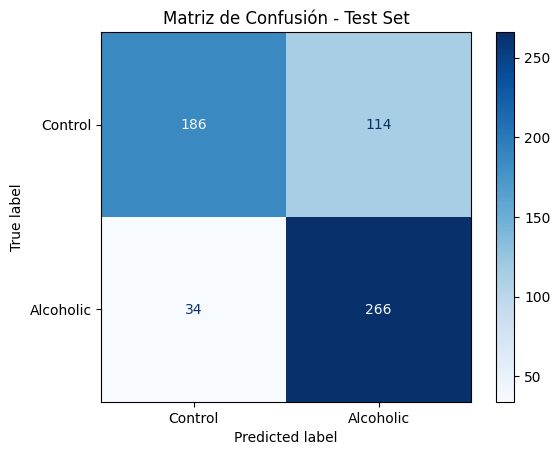


Reporte de Clasificación:
              precision    recall  f1-score   support

     Control       0.85      0.62      0.72       300
   Alcoholic       0.70      0.89      0.78       300

    accuracy                           0.75       600
   macro avg       0.77      0.75      0.75       600
weighted avg       0.77      0.75      0.75       600



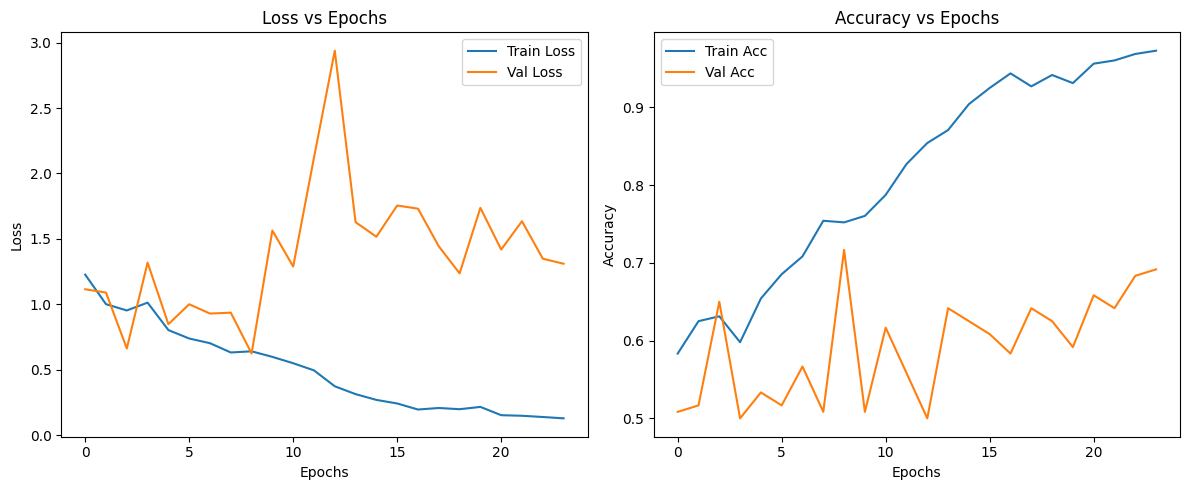

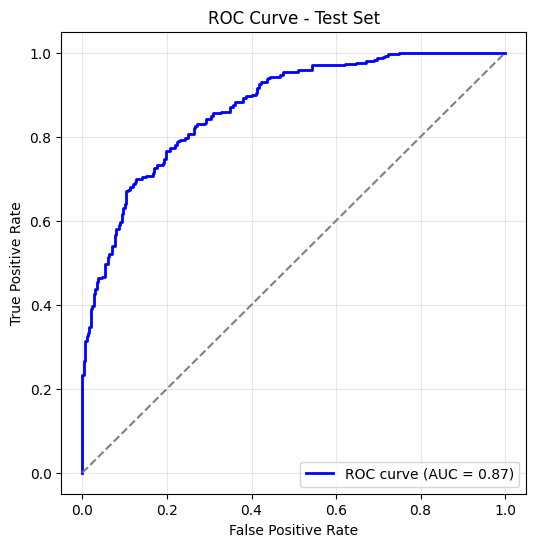

In [26]:
# ========================================================================
# 7. EVALUACIÓN EN TEST
# ========================================================================
print("\n" + "="*70)
print("PASO 7: EVALUACIÓN EN TEST SET")
print("="*70)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n{'='*50}")
print(f"RESULTADOS EN TEST SET")
print(f"{'='*50}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"{'='*50}\n")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Alcoholic'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Test Set')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Control', 'Alcoholic']))

from sklearn.metrics import roc_curve, auc

# =========================================
# Curvas de entrenamiento (loss y accuracy)
# =========================================
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# =========================================
# Curva ROC en Test
# =========================================
# y_test: labels verdaderos (0 o 1)
# y_pred_probs: probabilidades de salida del modelo (shape: [n_samples, 2])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])  # columna 1 = prob de clase positiva (alcoholic)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')  # línea diagonal aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


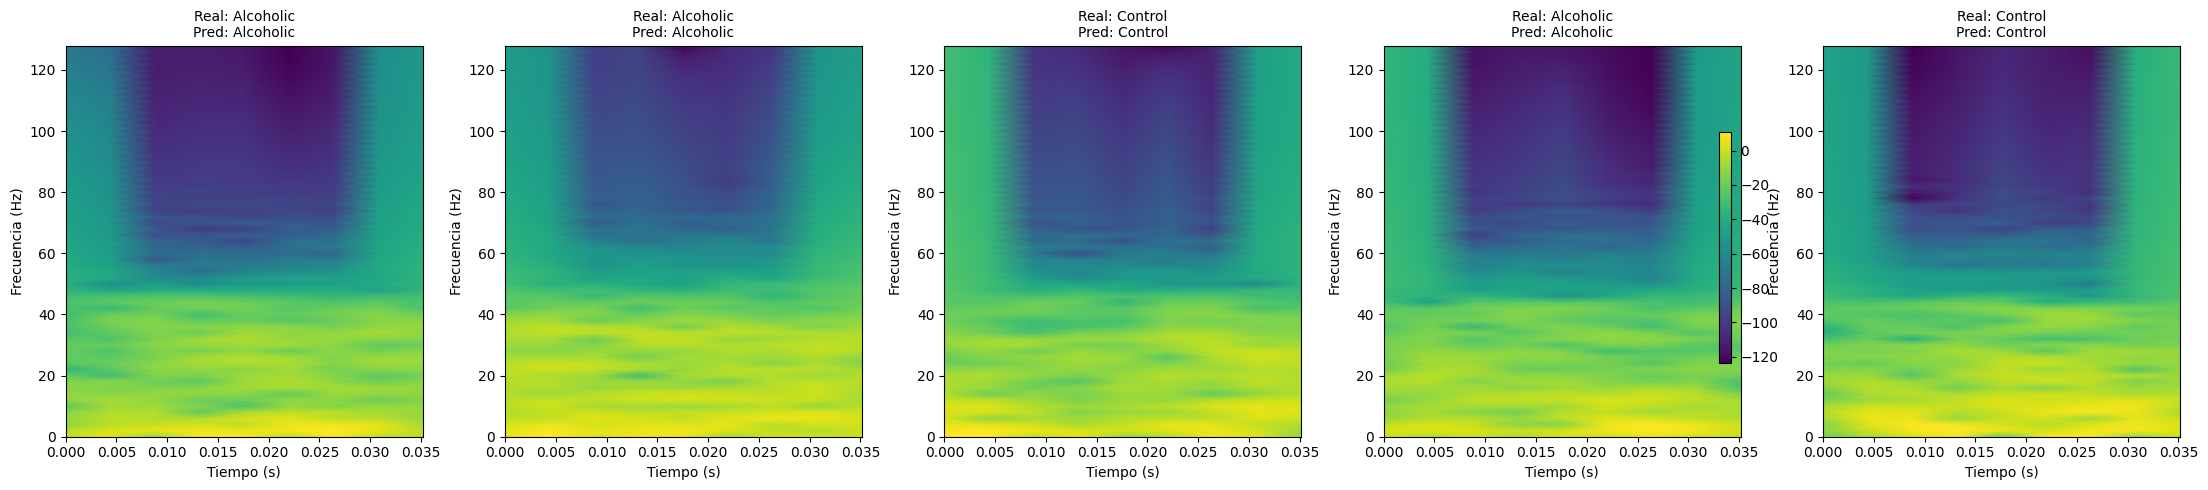

In [27]:
# Seleccionar 5 ejemplos aleatorios del test
indices = random.sample(range(len(X_test)), 5)

fig, axes = plt.subplots(1, 5, figsize=(22, 5))

for i, idx in enumerate(indices):
    # Datos del trial
    spec = X_test[idx]       # shape (freqs, times, canales)
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Usar el primer canal del trial
    img = spec[:, :, 0]

    # Dimensiones reales
    freqs = np.linspace(0, FS/2, img.shape[0])      # eje de frecuencias
    times = np.linspace(0, img.shape[1]/FS, img.shape[1])  # eje de tiempo

    ax = axes[i]
    pcm = ax.pcolormesh(times, freqs, img, shading='gouraud', cmap='viridis')
    ax.set_title(f"Real: {'Alcoholic' if true_label==1 else 'Control'}\nPred: {'Alcoholic' if pred_label==1 else 'Control'}",
                 fontsize=10)
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Frecuencia (Hz)")

fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()
